In [941]:
import torch
import higher
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
import tqdm
import os
import copy
import argparse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats.qmc import LatinHypercube

In [942]:
seed = 14
rng = np.random.RandomState(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [943]:
class StandardLearner():
    def __init__(self, model):
        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
    
    def train(self, X_train, y_train, n_epochs, 
                          batch_size, optimiser, loss_fn, loss_rec=True):
        X_train = torch.tensor(X_train, dtype=torch.float32).to(self.device)
        y_train = torch.tensor(y_train, dtype=torch.float32).to(self.device)
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        loss_record = []
        for _ in range(n_epochs):
            for X_batch, y_batch in train_loader:
                optimiser.zero_grad()
                y_pred = self.model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                if loss_rec:
                    loss_record.append(loss.item())
                loss.backward()
                optimiser.step()
        if loss_rec:
            return loss_record
        
    def predict(self, X_test):
        X_test = torch.tensor(X_test, dtype=torch.float32).to(self.device)
        y_pred = self.model(X_test)
        return y_pred.detach().cpu().numpy()
    
class MetaLearner():
    def __init__(self, model, outer_optim, inner_optim, loss_fn):
        self.model = model
        self.outer_optim = outer_optim
        self.inner_optim = inner_optim
        self.loss_fn = loss_fn
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def train(self, x_train, y_train, n_tasks, adaptation_steps,
                k_spt, return_loss=True, seed=None):
        
        loss_record = []

        rng = np.random.RandomState(seed)
        
        task_order = rng.permutation(n_tasks)
        for task in task_order:

            weights_before = copy.deepcopy(self.model.state_dict())
            
            # randomly choose task
            inds = rng.permutation(len(x_train))
            train_inds = inds[:-1*k_spt]
            val_inds = inds[-1*k_spt:]
            y_all = y_train[task]

            # Inner loop
            with higher.innerloop_ctx(self.model, self.inner_optim) as (fmodel, diffopt):
                for _ in range(adaptation_steps):
                    for start in range(0, len(train_inds), k_spt):
                        train_inds_batch = train_inds[start:start+k_spt]
                        x = torch.tensor(x_train[train_inds_batch,:], 
                                            dtype=torch.float32).to(self.device)
                        y = torch.tensor(y_all[train_inds_batch,:], 
                                            dtype=torch.float32).to(self.device)
                        
                        pred = fmodel(x)
                        loss = self.loss_fn(pred, y)
                        diffopt.step(loss)

            # Outer loop
            for start in range(0, len(val_inds), k_spt):
                val_inds_batch = val_inds[start:start+k_spt]
                x = torch.tensor(x_train[val_inds_batch,:], 
                                 dtype=torch.float32).to(self.device)
                y = torch.tensor(y_all[val_inds_batch,:], 
                                 dtype=torch.float32).to(self.device)
                
                self.model.zero_grad()
                pred = self.model(x)
                loss = self.loss_fn(pred, y)
                loss.backward()
                
                # Restore weights before inner adaptation
                self.model.load_state_dict(weights_before)
                
                # Take Meta step
                self.outer_optim.step()

            
            loss_record.append(loss.item())

        
        return loss_record
        
    def finetune_predict(self, x_train, y_train, x_test, finetune_optim, adaptation_steps):
        weights_before = copy.deepcopy(self.model.state_dict())
        with higher.innerloop_ctx(self.model, finetune_optim) as (fmodel, diffopt):
            for _ in range(adaptation_steps):
                x = torch.tensor(x_train, 
                                    dtype=torch.float32).to(self.device)
                y = torch.tensor(y_train, 
                                    dtype=torch.float32).to(self.device)
                
                pred = fmodel(x)
                loss = self.loss_fn(pred, y)
                diffopt.step(loss)

            x = torch.tensor(x_test, dtype=torch.float32).to(self.device)
            y_pred = fmodel(x)
        self.model.load_state_dict(weights_before)
        return y_pred.detach().cpu().numpy()
        
    def predict(self, x_test):
        x_test = torch.tensor(x_test, dtype=torch.float32).to(self.device)
        y_pred = self.model(x_test)
        return y_pred.detach().cpu().numpy()
    

In [944]:
# training data in this case needs different source dists
n_samples = 50
n_tasks = 100


Omega_b_arr = np.linspace(0.04, 0.06, n_samples)
Omega_c_arr = np.linspace(0.25, 0.35, n_samples)
h_arr = np.linspace(0.6, 0.8, n_samples)
sigma8_arr = np.linspace(0.7, 0.9, n_samples)
n_s_arr = np.linspace(0.9, 1.1, n_samples)

z = np.linspace(0., 3., 256)

l_arr = np.unique(np.geomspace(2, 60000, 30).astype(int))

if os.path.isfile('Cgg_data_multi_task.npz'):
    C_ells = np.load('Cgg_data_multi_task.npz')['C_ells']
    dndz = np.load('Cgg_data_multi_task.npz')['dndz']
else:
    print('Training data not found')

In [945]:
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, len(l_arr))
)

(5000, 29) (5000, 5)


Text(0, 0.5, 'Loss')

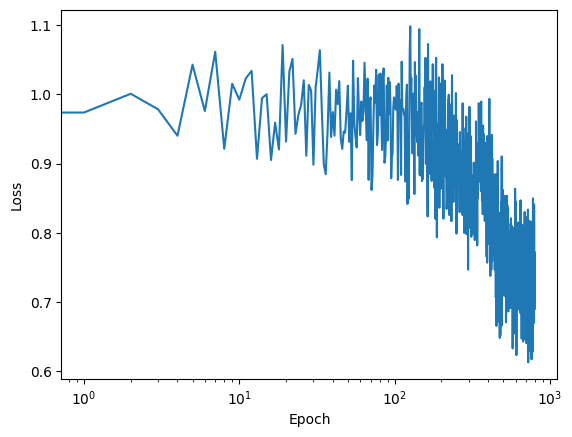

In [946]:
# Reshape training data for standard learning
#[n_samples, n_inputs]
X = np.vstack([Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr]).T
X = np.tile(X, (n_tasks, 1))

#[n_samples, n_outputs]
y = C_ells.reshape(-1, len(l_arr))
print(np.shape(y), np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Standardise training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)

batch_size = 512
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

CosyL = StandardLearner(model)
losses = CosyL.train(X_train, y_train, 100, batch_size, optimiser, loss_fn)

plt.plot(losses)
plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

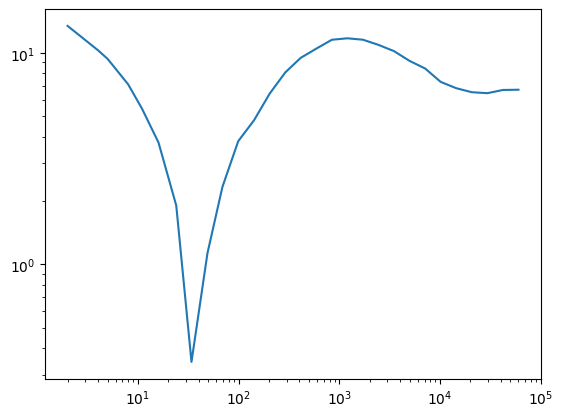

In [947]:
pred = CosyL.predict(X_test)
pred = scaler.inverse_transform(pred)
plt.loglog(l_arr, (abs(pred[0]-y_test[0])/y_test[0]*100), label='CosyL')

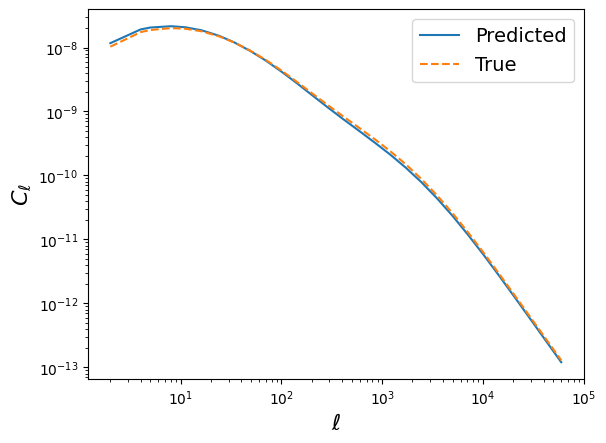

In [948]:
plt.loglog(l_arr, pred[0], label='Predicted', ls='-')
plt.loglog(l_arr, y_test[0], label='True', ls='--')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$C_{\ell}$', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('Cgg_pred.png', bbox_inches='tight')

(100, 50, 29) (50, 5)
[0.44167155027389526, 1.723240852355957, 454063.46875, inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


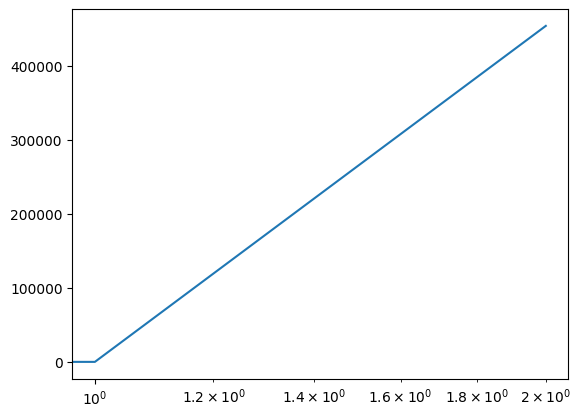

In [949]:
# Reshape training data for MAML
#[n_samples, n_inputs]
X = np.vstack([Omega_b_arr, Omega_c_arr, h_arr, sigma8_arr, n_s_arr]).T

scaler = StandardScaler()
X = scaler.fit_transform(X)

#[n_tasks, n_samples, n_inputs]
scaler_y = StandardScaler()
y = scaler.fit_transform(C_ells.reshape(-1, len(l_arr)))
y = y.reshape(n_tasks, n_samples, len(l_arr))
print(np.shape(y), np.shape(X))

inner_optim = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)
outer_optim = torch.optim.SGD(model.parameters(), lr=5e-1, weight_decay=1e-3)
loss_fn = nn.MSELoss()

CosyMAML = MetaLearner(model, loss_fn=loss_fn, inner_optim=inner_optim, outer_optim=outer_optim)
losses = CosyMAML.train(X, y, n_tasks=n_tasks, k_spt=10, adaptation_steps=1,  seed=seed)
plt.plot(losses)
plt.xscale('log')
print(losses)

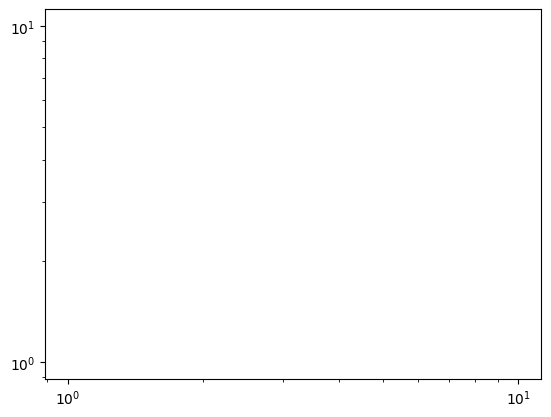

In [950]:
# Novel task
n_shots = 5

Omega_b = rng.uniform(0.04, 0.06, n_shots+1)
Omega_c = rng.uniform(0.25, 0.35, n_shots+1)
h = rng.uniform(0.6, 0.8, n_shots+1)
sigma8 = rng.uniform(0.7, 0.9, n_shots+1)
n_s = rng.uniform(0.9, 1.1, n_shots+1)

z0 = 0.2
dndz = 1./(2.*z0) * (z / z0)**2 * np.exp(-z/z0)

l_arr = np.unique(np.geomspace(2, 60000, 30).astype(int))

C_ells = np.zeros((n_shots+1, len(l_arr)))
for i in range(n_shots+1):
    cosmo = ccl.Cosmology(Omega_c=Omega_c[i], Omega_b=Omega_b[i], h=h[i], 
                          sigma8=sigma8[i], n_s=n_s[i])
    lensTracer = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz))
    C_ells[i] = ccl.angular_cl(cosmo, lensTracer, lensTracer, l_arr)

X_train = np.vstack([Omega_b[:-1], Omega_c[:-1], h[:-1], sigma8[:-1], n_s[:-1]]).T
X_test = np.vstack([Omega_b[-1], Omega_c[-1], h[-1], sigma8[-1], n_s[-1]]).T
y_train = C_ells[:-1]
y_test = C_ells[-1]

# Standardise training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)

CosyL.train(X_train, y_train, 32, batch_size, optimiser, loss_fn)
pred = CosyL.predict(X_test)
pred = scaler.inverse_transform(pred)
plt.loglog(l_arr, (abs(pred[0]-y_test)/y_test*100), label='CosyL')

